In [1]:
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

# Load the pre-trained transformer model
model_name = "bert-base-multilingual-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Add attention mechanism
class Attention(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attn = torch.nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = torch.nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, attention_mask):
        # hidden_states shape: (batch_size, seq_length, hidden_dim)
        # attention_mask shape: (batch_size, seq_length)
        seq_length = hidden_states.size(1)
        h = hidden_states.unsqueeze(2).expand(-1, -1, seq_length, -1)  # shape: (batch_size, seq_length, seq_length, hidden_dim)
        h_t = hidden_states.unsqueeze(1).expand(-1, seq_length, -1, -1)  # shape: (batch_size, seq_length, seq_length, hidden_dim)
        concatenated = torch.cat([h, h_t], dim=-1)  # shape: (batch_size, seq_length, seq_length, hidden_dim * 2)
        concatenated = concatenated.view(-1, seq_length, seq_length, self.hidden_dim * 2)
        energy = torch.tanh(self.attn(concatenated))  # shape: (batch_size, seq_length, seq_length, hidden_dim)
        energy = energy.view(-1, seq_length, seq_length, self.hidden_dim)
        v = self.v(energy).squeeze(-1)  # shape: (batch_size, seq_length, seq_length)
        v = v.masked_fill(attention_mask.unsqueeze(1) == 0, -1e9)
        attn_weights = torch.softmax(v, dim=-1)  # shape: (batch_size, seq_length, seq_length)
        context_vector = torch.einsum("bsj,bsj->bs", attn_weights, hidden_states)  # shape: (batch_size, hidden_dim)
        return context_vector, attn_weights

# Define dataset class for Urdu news
class UrduNewsDataset(Dataset):
    def __init__(self, data, max_len):
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]["NEWS"])
        label = int(self.data.iloc[index]["LABELS"])
        inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }
    
# Load and preprocess the data
data = pd.read_csv("3sentiments1.csv")
train_data, test_data = train_test_split(data, test_size=0.2)
train_dataset = UrduNewsDataset(train_data, max_len=128)
test_dataset = UrduNewsDataset(test_data, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [2]:
# # Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predictions = torch.max(logits, dim=1)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += torch.sum(predictions == labels).item()
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    
    # Evaluate the model on the test set
    test_loss = 0.0
    test_correct = 0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, predictions = torch.max(logits, dim=1)
            loss = loss_fn(logits, labels)
            test_loss += loss.item()
            test_correct += torch.sum(predictions == labels).item()
        test_loss /= len(test_loader)
        test_acc = test_correct / len(test_loader.dataset)
    
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.4f}")

Epoch 1 - Train Loss: 0.7279 - Train Acc: 0.5550 - Test Loss: 0.5858 - Test Acc: 0.7467
Epoch 2 - Train Loss: 0.5698 - Train Acc: 0.7117 - Test Loss: 0.5124 - Test Acc: 0.7700
Epoch 3 - Train Loss: 0.3898 - Train Acc: 0.8333 - Test Loss: 0.6690 - Test Acc: 0.6800
Epoch 4 - Train Loss: 0.2661 - Train Acc: 0.8900 - Test Loss: 0.6416 - Test Acc: 0.7400
Epoch 5 - Train Loss: 0.1390 - Train Acc: 0.9542 - Test Loss: 0.7858 - Test Acc: 0.7567


In [3]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predictions = torch.max(logits, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(predictions.tolist())

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred))

Confusion matrix:
[[ 97  43]
 [ 30 130]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       140
           1       0.75      0.81      0.78       160

    accuracy                           0.76       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.76      0.76       300



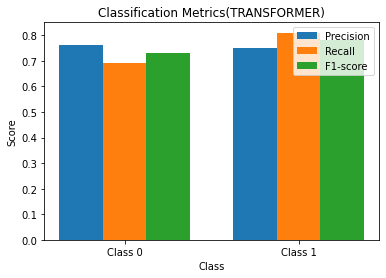

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class labels
class_labels = ['Class 0', 'Class 1']

# Define the precision, recall, and F1-score for each class
precision = [0.76, 0.75]
recall = [0.69, 0.81]
f1_score = [0.73, 0.78]

# Define the x-axis locations for the bars
x_ticks = np.arange(len(class_labels))

# Set the bar width
bar_width = 0.25

# Plot the precision, recall, and F1-score for each class as separate bars
fig, ax = plt.subplots()
ax.bar(x_ticks - bar_width, precision, bar_width, label='Precision')
ax.bar(x_ticks, recall, bar_width, label='Recall')
ax.bar(x_ticks + bar_width, f1_score, bar_width, label='F1-score')

# Add labels, title, and legend
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics(TRANSFORMER)')
ax.set_xticks(x_ticks)
ax.set_xticklabels(class_labels)
ax.legend()

# Show the plot
plt.show()

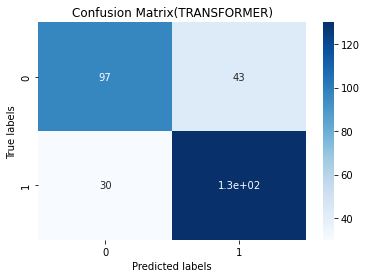

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix heatmap using seaborn
sns.heatmap(conf_matrix, annot=True, cmap="Blues")

# Add labels and title to the plot
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix(TRANSFORMER)")

# Show the plot
plt.show()

In [20]:
print("  ************ TRANSFORMER **********")
text = "امریکا سے آکر خاتون نے سندھ کے اسپتال سے آپریشن کروالیا"
inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    _, predictions = torch.max(logits, dim=1)
sentiment = predictions.item()
print(text)
if sentiment == 0:
    print("Negative")
elif sentiment == 1:
    print("Neutral")
else:
    print("Positive")


  ************ TRANSFORMER **********
امریکا سے آکر خاتون نے سندھ کے اسپتال سے آپریشن کروالیا
Neutral
